# Toxicity Type Detection

In this notebook, we will train a baseline model to predict the toxicity types of toxic comments.

We will use [simpletransformers](https://simpletransformers.ai/) that is a wrapper for many popular models available in [Hugging Face](https://huggingface.co/).

We will use a pre-trained model ([neuralmind/bert-base-portuguese-cased · Hugging Face](https://huggingface.co/neuralmind/bert-base-portuguese-cased)) that is trained on Portuguese.

In [1]:
import sys
from pathlib import Path

if str(Path(".").absolute().parent) not in sys.path:
    sys.path.append(str(Path(".").absolute().parent.parent))

In [2]:
from dotenv import load_dotenv

# Initialize the env vars
load_dotenv("../../.env")

True

In [3]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda import is_available
from sklearn.metrics import classification_report
from simpletransformers.classification import (
    MultiLabelClassificationModel,
    MultiLabelClassificationArgs
)

from src.modeling.selection import multilabel_train_test_split
from src.modeling.utils import (
    download_dataset,
    get_dataset_version,
    prep_data,
    clean_simpletransformers,
    compute_pos_weight,
    get_labels_for_y
)

%matplotlib inline

sns.set_theme(style="whitegrid", palette="pastel")

logging.basicConfig(level=logging.INFO)

_logger = logging.getLogger("transformers")
_logger.setLevel(logging.WARNING)

params = {
    "seed": 1993,
    "model_type": "bert",
    "model_name": "neuralmind/bert-base-portuguese-cased",
    "num_train_epochs": 6,
    "use_cuda": is_available()
}

## Load the data

In this section, we will download the data and load it into a pandas dataframe.

In [4]:
files = download_dataset(
    ["train.csv", "test.csv"]
)

train_data = files["train.csv"]
test_data = files["test.csv"]

print(f"Training set: {train_data.shape}")
train_data.head()

Shape: (4765, 17)


,id,text,is_offensive,is_targeted,targeted_type,toxic_spans,health,ideology,insult,lgbtqphobia,other_lifestyle,physical_aspects,profanity_obscene,racism,religious_intolerance,sexism,xenophobia
0,430b13705cf34e13b74bc999425187c3,USER USER é muito bom. USER ^^ E claro a equip...,NOT,UNT,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False
1,c779826dc43f460cb18e8429ca443477,Pior do que adolescentezinhas de merda...são p...,OFF,UNT,NaN,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,False,True,False,False,False,True,False,False,True,False
2,e64148caa4474fc79298e01d0dda8f5e,USER Toma no cu é vitamina como tu e tua prima.,OFF,TIN,GRP,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...",False,False,True,False,False,False,True,False,False,False,False
3,cc66b54eeec24607a67e2259134a1cdd,"Muito bom, pena a circunstâncias serem ruins, ...",OFF,UNT,NaN,"[119, 120, 121, 122, 123, 124, 125, 126, 127, ...",False,False,True,False,False,False,False,False,False,False,False
4,a3d7839456ae4258a70298fcf637952e,"Podia ter beijo também, pra ver se o homofóbic...",OFF,UNT,NaN,"[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...",False,False,True,False,False,False,False,False,False,False,False


In [5]:
print(f"Test set: {test_data.shape}")
test_data.head()

Shape: (1589, 17)


,id,text,is_offensive,is_targeted,targeted_type,toxic_spans,health,ideology,insult,lgbtqphobia,other_lifestyle,physical_aspects,profanity_obscene,racism,religious_intolerance,sexism,xenophobia
0,da19df36730945f08df3d09efa354876,USER Adorei o comercial também Jesus. Só achei...,OFF,UNT,NaN,"[52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 6...",False,False,True,False,False,False,True,False,False,False,False
1,80f1a8c981864887b13963fed1261acc,Cara isso foi muito babaca geral USER conhece ...,OFF,TIN,GRP,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,False,True,False,False,False,False,False,False,False,False
2,2f67025f913e4a6292e3d000d9e2b5a8,"Se vc for porco, folgado e relaxado, você não ...",OFF,UNT,NaN,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,False,True,False,False,False,False,False,False,False,False
3,738ccd4476784f47af3a5a6cfdda4695,Se fosse um sniper ia ser louco,OFF,UNT,NaN,"[26, 27, 28, 29, 30]",False,False,True,False,False,True,False,False,False,False,False
4,e0064da693bd4c9e90ce8e6db8bd3bbb,USER é o meu saco USER USER USER,OFF,UNT,NaN,"[13, 14, 15, 16]",False,False,True,False,False,False,True,False,False,False,False


In [6]:
toxicity_labels = [
    "health",
    "ideology",
    "insult",
    "lgbtqphobia",
    "other_lifestyle",
    "physical_aspects",
    "profanity_obscene",
    "racism",
    "sexism",
    "xenophobia"
]

def filter_data(df: pd.DataFrame):
    # Filter only offensive comments
    df = df[df["is_offensive"] == "OFF"]

    # Remove religious_intolerance that has only one  sample
    df = df[df["religious_intolerance"] == False]

    df.drop(columns=["religious_intolerance"], inplace=True)

    # Filter only offensive comments with at least one toxicity label
    df = df.loc[df.select_dtypes('bool').sum(axis=1).ge(1)]

    df.reset_index(drop=True, inplace=True)
    return df

train_data = filter_data(train_data)
test_data = filter_data(test_data)

print(f"Shape: {train_data.shape}")
print(f"Shape: {test_data.shape}")

Shape: (4272, 16)
Shape: (1438, 16)


## Exploratory Data Analysis (EDA)

In the next section, we will perform some exploratory data analysis (EDA) to understand the data.

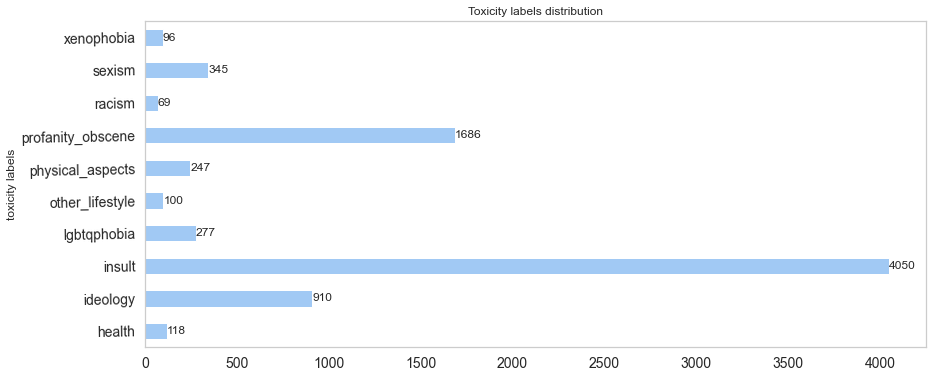

In [7]:
df_eda = train_data[["text"]+toxicity_labels]

ax = df_eda[toxicity_labels].sum().plot(kind="barh", grid=False,
                                        legend=False, figsize=(14, 6),
                                        xlabel="toxicity labels", ylabel="count", fontsize=14,
                                        rot=1, title="Toxicity labels distribution")

for container in ax.containers:
    ax.bar_label(container, fontsize=12)

## Prepare the data

In this section, we will prepare the data in order to train the model.

The `simpletransformers` library expects the data in a specific format.

More information about the format can be found in the [Classification Data Formats - Simple Transformers](https://simpletransformers.ai/docs/classification-data-formats/#binary-classification)

In [8]:
X_train = train_data["text"].values
y_train = train_data[toxicity_labels].astype(int).values

X_test = test_data["text"].values
y_test = test_data[toxicity_labels].astype(int).values

train_data = prep_data(X_train, y_train)
test_data = prep_data(X_test, y_test)

df_train = pd.DataFrame(train_data)
df_train.columns = ["text", "labels"]

df_test = pd.DataFrame(test_data)
df_test.columns = ["text", "labels"]

print(f"train_data: {df_train.shape}")
print(f"test_data: {df_test.shape}")

train_data: (4272, 2)
test_data: (1438, 2)


## Training the model

In this section, we will train a baseline model to predict if a toxic comment is targeted or not.

We will not perform hyperparameter tuning because it is a simple baseline model.

In [ ]:
clean_simpletransformers()
        
# Compute class weights
params["pos_weights"] = compute_pos_weight(y_train)

# Optional model configuration
model_args = MultiLabelClassificationArgs(
    num_train_epochs=params["num_train_epochs"])

# Create a ClassificationModel
model = MultiLabelClassificationModel(
    model_type=params["model_type"],
    model_name=params["model_name"],
    num_labels=len(toxicity_labels),
    args=model_args,
    pos_weight=params["pos_weights"],
    use_cuda=params["use_cuda"]
)

# Train the model
model.train_model(df_train)

## Evaluating the model

In this section, we will evaluate the model with the following metrics:

- **Accuracy**: the percentage of correct predictions;
- **Precision**: the percentage of predicted targeted comments that are actually targeted;
- **Recall**: the percentage of targeted comments that are actually predicted as targeted;
- **F1-Score**: the harmonic mean of precision and recall;
- **ROC AUC**: the area under the receiver operating characteristic Curve (ROC AUC).

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(df_test)

y_true = df_test["labels"].tolist()

y_pred, raw_outputs = model.predict(df_test["text"].tolist())

## Testing the model

In the last section, we will test the model with some comments from the test set.

In [ ]:
df_pred = df_test.head(20)

predictions, raw_outputs = model.predict(df_pred["text"].tolist())

df_pred = df_pred.assign(predictions=predictions)

df_pred["labels"] = df_pred["labels"].apply(lambda x: get_labels_for_y(x, toxicity_labels))
df_pred["predictions"] = df_pred["predictions"].apply(lambda x: get_labels_for_y(x, toxicity_labels))

df_pred.to_csv("pred.csv", index=False, encoding="utf-8")

df_pred

In [ ]:
clean_simpletransformers()